In [1]:
from surprise import KNNBasic, Dataset, Reader, model_selection, SVD, KNNBasic
from collections import defaultdict
import heapq
import pandas as pd
from datetime import datetime
import numpy as np

In [2]:
def dateparse (time_in_secs):    
    return datetime.fromtimestamp(float(time_in_secs))

In [3]:
def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)

    for uid, iid, _, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():        
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [4]:
# Load in the data  and return train and test sets.
def load_dataset(df):
    reader = Reader(line_format='user item rating', rating_scale=(1, 5), sep=',', skip_lines=0)
    ratings_dataset = Dataset.load_from_df(df, reader)
    # Split the dataset into training and test sets
    return model_selection.train_test_split(ratings_dataset, test_size=0.20, shuffle=False)
    

In [5]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = {}

    recalls = {}
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

In [6]:
df=pd.read_csv('ai case study.csv',
               names=['user_id','product_id','rating','timestamp'],
               dtype={'user_id':'category','product_id':'category', 'rating':'int'},
               parse_dates=['timestamp'],
               date_parser=dateparse
              )

In [7]:
print(f'Number os users: {len(df.user_id.unique())}')
print(f'Number of items: {len(df.product_id.unique())}')
print(f'Rating Scale: {int(df.rating.min())} - {int(df.rating.max())}')
print(f'Date range: {df.timestamp.min()} - {df.timestamp.max()}')

Number os users: 4201696
Number of items: 476002
Rating Scale: 1 - 5
Date range: 1998-12-04 03:00:00 - 2014-07-23 03:00:00


Frequency of each rating

<AxesSubplot: >

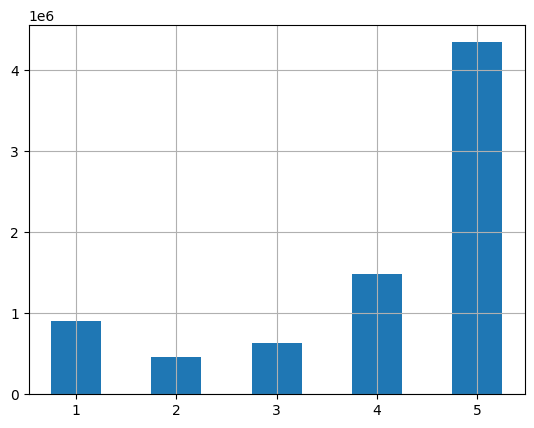

In [8]:
df.rating.hist(bins=range(1,7), align='left', rwidth=0.5)

Sort the dataframe by date so that when we split the data we test on the future

In [9]:
df = df.sort_values(by='timestamp', inplace = False).reset_index(drop=True)

Trying different recommendation techniques, user-based collaborative filltering and item-based collaborative filltering. We split the data into train and test set using the load_dataset function.

In [10]:
trainset_i, testset_i = load_dataset(df[['product_id', 'user_id', 'rating']]) # item based
trainset_u, testset_u = load_dataset(df[['user_id', 'product_id', 'rating']]) # user based

We define SVD, a matrix factorizing algorithm and fit the training data.

In [11]:
algo_i = SVD() # item based
algo_u = SVD() # user based
algo_i.fit(trainset_i)
algo_u.fit(trainset_u)

We test our laerned algorithm on the testset we defined earlier.

In [12]:
results_i = algo_i.test(testset_i) # item based
results_u = algo_u.test(testset_u) # user based

Swap two columns of the user and item to be able to measure the results.

In [13]:
# (switching item with user to measure the results)
results_ip = [[w, v, x, y, z] for v, w, x, y, z in results_i] # processing

We use precision_recall_at_k function to calculate the precision and recall.

In [14]:
precisions_i, recalls_i = precision_recall_at_k(results_ip, 5) # top 5
precisions_u, recalls_u = precision_recall_at_k(results_u, 5) # top 5

In [15]:
print(f'avg_precision_i: {np.mean(list(precisions_i.values()))}')
print(f'avg_recall_i: {np.mean(list(recalls_i.values()))}')
print(f'avg_precision_u: {np.mean(list(precisions_u.values()))}')
print(f'avg_recall_u: {np.mean(list(recalls_u.values()))}')


avg_precision_i: 0.7027318635233006
avg_recall_i: 0.7197603490381925
avg_precision_u: 0.7028176631567111
avg_recall_u: 0.7199162962884823


Visualize the results for one user

In [16]:
test = df[-int(len(df)*0.2):] # taking last 20% of the data
predictions = [algo_u.predict('A1WVMDRJU19AFD', item_id) for item_id in test.product_id.unique()]

In [17]:
top_n = get_top_n(predictions, n=5)

In [18]:
list(top_n.values())

[[('B00622AG6S', 5),
  ('B004HFJGYU', 5),
  ('B009W8EWOG', 5),
  ('B00913NPYK', 5),
  ('B00DVFLJDS', 5)]]

Here we try different approach, we will use a similarity algorithm

In [19]:
trainset, testset = load_dataset(df[['user_id', 'product_id', 'rating']][:30000]) # Can't use all data due to lack of memory

Again, we will try both item and user based collaborative filtering

In [20]:
similarity_matrix_i = KNNBasic(sim_options={
        'name': 'cosine',
        'user_based': False
        })\
        .fit(trainset)
similarity_matrix_u = KNNBasic(sim_options={
        'name': 'cosine',
        'user_based': True
        })\
        .fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [21]:
results_i = similarity_matrix_i.test(testset)
results_u = similarity_matrix_u.test(testset)

In [22]:
precisions_i, recalls_i = precision_recall_at_k(results_i, 6000, threshold=3.5)
precisions_u, recalls_u = precision_recall_at_k(results_u, 6000, threshold=3.5)

In [23]:
print(f'avg_precision_i: {np.mean(list(precisions_i.values()))}')
print(f'avg_recall_i: {np.mean(list(recalls_i.values()))}')
print(f'avg_precision_u: {np.mean(list(precisions_u.values()))}')
print(f'avg_recall_u: {np.mean(list(recalls_u.values()))}')

avg_precision_i: 0.6951013630628007
avg_recall_i: 0.7081242980157245
avg_precision_u: 0.6948213617157833
avg_recall_u: 0.7077172889509094


Visualizing on one user

In [24]:
# Example one case
test_subject_iid = trainset.to_inner_uid('A1WVMDRJU19AFD')

# Get the top K items we rated
test_subject_ratings = trainset.ur[test_subject_iid]
k_neighbors = heapq.nlargest(5, test_subject_ratings, key=lambda t: t[1])

In [25]:
similarity_matrix = similarity_matrix_i.compute_similarities()
candidates = defaultdict(float)

for itemID, rating in k_neighbors:
    try:
      similaritities = similarity_matrix[itemID]
      for innerID, score in enumerate(similaritities):
          candidates[innerID] += score * (rating / 5.0)
    except:
      continue

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [26]:
rated = {}
for itemID, _ in trainset.ur[test_subject_iid]:
  rated[itemID] = 1

# Add items to list of user's recommendations
# If they are similar to their favorite items,
# AND have not already been rated it.
recommendations = []

position = 1
for itemID, rating_sum in sorted(candidates.items(), key=itemgetter(1), reverse=True):
  if not itemID in rated:
    recommendations.append(trainset.to_raw_iid(itemID))
    position += 1
    if (position > 5): break # We only want top 5

for idx, rec in enumerate(recommendations, 1):
  print(f"Product {idx}:", rec)

Product 1: B00002SWHH
Product 2: B00004SC3Y
Product 3: B000031KIM
Product 4: B00000J3Q7
Product 5: B00001QEMF
